<a href="https://colab.research.google.com/github/GP-FCI-SU/Breast-Cancer-Detection-with-Convolutional-Neural-Networks/blob/master/model_4_e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

updated version of model_4_d .here we change the classes wieght (0:1)with (4:7) with the pixel values in images are scaled between 0 and 1

In [ ]:
import zipfile
local_zip = '/content/drive/My Drive/ddsm-mammography.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/ddsm')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'2.2.0'

In [ ]:
features={#needed features to feed into our model  
            
            'label_normal': tf.io.FixedLenFeature([], tf.int64),
            'image': tf.io.FixedLenFeature([], tf.string)
        }#we have also the label feature but not used here

#make a function that will applied to the map transformation
def _parse_image_function(example_proto):
  parsed=tf.io.parse_single_example(example_proto,features)
  image = tf.io.decode_raw(parsed["image"], tf.uint8)
  image = tf.cast(image, tf.float32)/255.0
  image = tf.reshape(image, shape=[299,299,1])#our image shape and model expected one
   #X_adj = tf.divide(X_adj, scale
  label = tf.cast(parsed["label_normal"], tf.int32) 
  return image,label #atuple of two tensos

In [ ]:
def get_dataset(filenames):
  dataset = tf.data.Dataset.list_files(filenames)
  dataset = dataset.interleave(tf.data.TFRecordDataset,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(_parse_image_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #dataset = dataset.cache() # This dataset fits in RAM
  #dataset = dataset.repeat()
  #dataset = dataset.shuffle(2048)
  dataset = dataset.batch(batch_size=16) # drop_remainder will be needed on TPU
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
def load_val():
   X_cv = np.load( "/tmp/ddsm/test10_data/test10_data.npy")
   labels = tf.cast(np.load( "/tmp/ddsm/test10_labels.npy"),tf.int8)
   y_cv = np.zeros(len(labels))
   y_cv[labels != 0] = 1
   # X_cv = (X_cv - 127.0) / 255.0
  # X_cv = X_cv / 255.0
   X_cv= tf.cast(X_cv, tf.float32)/255.0
   return X_cv, y_cv

In [ ]:
def get_training_dataset():
  return get_dataset(["/tmp/ddsm/training10_0/training10_0.tfrecords",
                     "/tmp/ddsm/training10_1/training10_1.tfrecords",
                     "/tmp/ddsm/training10_2/training10_2.tfrecords",
                     "/tmp/ddsm/training10_3/training10_3.tfrecords",
                     "/tmp/ddsm/training10_4/training10_4.tfrecords"]
                     )
def get_test_dataset():
  test_dataset = tf.data.Dataset.from_tensor_slices(load_val())
  test_dataset= test_dataset.batch(batch_size=16)
  test_dataset=test_dataset.cache()
  return test_dataset

test_dataset=get_test_dataset()
def get_validation_dataset():
  return test_dataset


In [ ]:
model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D( 32, (3,3), activation='relu', input_shape=(299,299,1)),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),   
    tf.keras.layers.MaxPooling2D((3,3),strides=2),
    
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),

   tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
   tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
   tf.keras.layers.MaxPooling2D((2,2),strides=2),

   tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
   tf.keras.layers.MaxPooling2D((2,2),strides=2),

   tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
   tf.keras.layers.MaxPooling2D((2,2),strides=2),
   # tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(2048,activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 293, 293, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 146, 146, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 144, 144, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 142, 142, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 71, 71, 64)        0

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      if epoch>13:
        self.model.save("/tmp/model_4_e_e{},{:.2f},{:.2f},{:.2f},{:.2f}.h5".format(epoch,logs['acc'],logs['loss'],logs['val_acc'],logs['val_loss']))

In [ ]:
class_weights = {1: 0.64,
                 0: 0.36}

In [ ]:
#from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
callback=myCallback()
history = model.fit(
    get_training_dataset(),
     validation_data=get_validation_dataset(), 
      epochs=30,
      verbose=1,
      callbacks=[callback],
      class_weight=class_weights
      )

Epoch 1/30
3493/3493 [==============================] - 1098s 314ms/step - loss: 0.1530 - acc: 0.8774 - val_loss: 0.1972 - val_acc: 0.9318
Epoch 2/30
3493/3493 [==============================] - 1094s 313ms/step - loss: 0.1343 - acc: 0.8915 - val_loss: 0.2272 - val_acc: 0.9219
Epoch 3/30
3493/3493 [==============================] - 1091s 312ms/step - loss: 0.1230 - acc: 0.8965 - val_loss: 0.2533 - val_acc: 0.9150
Epoch 4/30
3493/3493 [==============================] - 1093s 313ms/step - loss: 0.1181 - acc: 0.8990 - val_loss: 0.2111 - val_acc: 0.9074
Epoch 5/30
3493/3493 [==============================] - 1092s 312ms/step - loss: 0.1159 - acc: 0.8994 - val_loss: 0.2039 - val_acc: 0.9272
Epoch 6/30
3493/3493 [==============================] - 1091s 312ms/step - loss: 0.1198 - acc: 0.9001 - val_loss: 0.1861 - val_acc: 0.9296
Epoch 7/30
3493/3493 [==============================] - 1091s 312ms/step - loss: 0.1067 - acc: 0.9077 - val_loss: 0.4725 - val_acc: 0.7902
Epoch 8/30
3493/3493 [=====

In [ ]:
def load_val():
   X_cv = np.load( "/tmp/ddsm/test10_data/test10_data.npy")
   labels = tf.cast(np.load( "/tmp/ddsm/test10_labels.npy"),tf.int8)
   y_cv = np.zeros(len(labels))
   y_cv[labels != 0] = 1
   # X_cv = (X_cv - 127.0) / 255.0
  # X_cv = X_cv / 255.0
   X_cv= tf.cast(X_cv, tf.float32)/255.0
   return X_cv, y_cv
yhat=model.predict_classes(get_validation_dataset() )
yhat = yhat[:, 0]
_,y=load_val()
recall = recall_score(y, yhat)
print('Recall: %f' % recall)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Recall: 0.673653


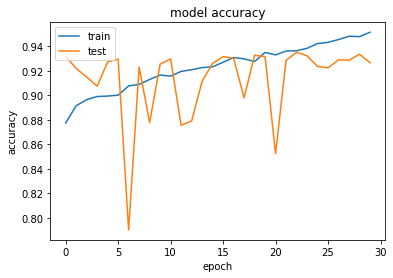

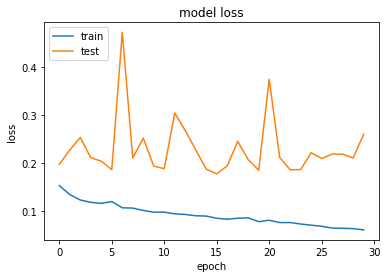

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
fig = plt.figure(figsize=(24,100))

cnt=1

ds=get_validation_dataset()

for imgs,lbls in ds.take(8):
  predicted_classes=model.predict_classes(imgs)
  for img,lbl,cl in zip(imgs,lbls,predicted_classes):
    fig.add_subplot(32,4, cnt)
    plt.title('{}/{}'.format(cl,int(lbl)))
    plt.imshow(tf.reshape(img, shape=[299,299]))
    cnt=cnt+1
#print(predicted_classes)


NameError: ignored

<Figure size 1728x7200 with 0 Axes>

In [ ]:
from os import listdir
from os.path import isfile, join
import shutil
onlyfiles = [f for f in listdir('/tmp') if isfile(join('/tmp', f))]
for file in onlyfiles:
    if file.startswith('model_4_e_e29') and file.endswith(".h5"):    
        print(file)
        shutil.copy(join('/tmp', file),join('/content/drive/My Drive/models',file))
